<a href="https://colab.research.google.com/github/jasminjahanpuspo/MS_Thesis/blob/main/BM_S_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<font color='yellow'>Model Name: InceptionV3</font>**


# Step 1: Setup Environment

##### 🔹 Mount Google Drive
*   Access datasets stored in your Google Drive.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 🔹 Import Required Libraries
*   Load all necessary libraries for image processing, data handling, and visualization.
*   Load TensorFlow, Keras, and layers for building CNN models.

In [1]:
# ============================================================
#  Libraries for Data Handling
# ============================================================
import os                      # File and directory operations
import glob as gb              # File pattern matching (e.g., get all image paths)
import numpy as np             # Numerical operations and arrays
import pandas as pd            # Data manipulation and analysis

# ============================================================
#  Libraries for Image Processing
# ============================================================
import cv2                     # OpenCV for image reading and preprocessing
from PIL import Image          # Image loading and manipulation

# ============================================================
#  Libraries for Visualization
# ============================================================
import matplotlib.pyplot as plt # Plotting graphs and images
import seaborn as sns           # Advanced visualizations (e.g., heatmaps)
%matplotlib inline
import matplotlib

# ============================================================
#  Utilities and Helpers
# ============================================================
import random                  # For random sampling and augmentations
import math                    # Mathematical operations
import time                    # Measure training time and performance


In [3]:
# ============================================================
# TensorFlow & Keras Core Libraries
# ============================================================
import tensorflow as tf                       # Core TensorFlow library
from tensorflow import keras                  # High-level API for deep learning
from tensorflow.keras import layers, models   # Layers and model-building utilities

# ============================================================
# Dataset Utilities
# ============================================================
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Load and preprocess image datasets from directory structures

# ============================================================
# Layers for CNN Architectures
# ============================================================
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten,
    Conv2D, MaxPool2D, LeakyReLU
)


# Step 2: Prepare Dataset
Load and preprocess train, validation, and test datasets for model input.

##### 🔹 Create TensorFlow Datasets


*   Load images from the directories into TensorFlow datasets for training, validation, and testing.  
*   Adjust `image_size` and `batch_size` as needed.



In [4]:
## Define the directories for training, testing, and validation
train_directory = '/content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/bangla_banknote_v2/Training/aug_train'
test_directory = '/content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/bangla_banknote_v2/Training/split/test'
valid_directory = '/content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/bangla_banknote_v2/Training/split/val'

In [5]:
IMG_SIZE = (224, 224)  # define resolution (299,299) /(224,224)
BATCH_SIZE = 128       # varies from dataset to datset prefferable 128/68/32

In [6]:
# Create TensorFlow datasets for training, testing, and validation
#you can customize parameters as per dataset
train_dataset = image_dataset_from_directory(
    train_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

test_dataset = image_dataset_from_directory(
    test_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

valid_dataset = image_dataset_from_directory(
    valid_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

Found 1950 files belonging to 9 classes.
Found 93 files belonging to 9 classes.
Found 78 files belonging to 9 classes.


In [7]:
# Automatically detect number of classes from dataset
class_names = train_dataset.class_names  # works with image_dataset_from_directory
n_classes = len(class_names)

print("Detected Classes:", class_names)
print("Number of Classes:", n_classes)

Detected Classes: ['1', '10', '100', '1000', '2', '20', '5', '50', '500']
Number of Classes: 9


In [ ]:
class_counts = []
for i in range(len(train_dataset.class_names)):
    class_counts.append(sum(1 for _, label in train_dataset.unbatch().as_numpy_iterator() if label == i))

Dataset = class_counts  # now your class weights will adapt automatically

In [8]:
# Convert dataset labels to a single NumPy array
labels = np.array([label for _, label in train_dataset.unbatch().as_numpy_iterator()])

# Count per class
class_counts = np.bincount(labels)
print(class_counts)


[105 255 247 208 253 203 253 261 165]


In [9]:
Dataset = class_counts  # now your class weights will adapt automatically

# Step 3: Model Training
This step involves setting up the CNN model architecture (e.g., DenseNet121, InceptionV3, ResNet50), configuring the input shape, downloading pretrained weights (e.g., ImageNet), and compiling the model for training.

##### 🔹 Initialize Base Model
*   Download pretrained weights and load the base CNN model.  

In [10]:
base_learning_rate = 0.001 # prefferable lr is 0.0001 or 0.001
IMG_SHAPE = IMG_SIZE +(3,)


##### 🔹 Download pretrained weights and initialize base model
*  Load the CNN base model with pretrained weights for transfer learning.  

In [11]:
## N.B:download the weights (imagenet/...) and model (Resnet50/ResNet100/InceptionV3...)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##### 🔹 Preprocessing function
*   Apply model-specific preprocessing to input images.  



In [12]:
type(base_model)
## N.B: change the model name
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

##### 🔹 Model summary info
*   View layer-wise details of the base model.  

In [13]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 311
activation_93
mixed10


In [ ]:
# Print all layers with index, name, and type
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.__class__.__name__)


##### 🔹 Feature extraction preview
*   Inspect features extracted from input images by the base model.

In [15]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 5, 5, 2048)


##### 🔹 Create custom classification model
*  Add dense/classification layers on top of the base model.  

In [16]:
def create_model( image_shape=IMG_SHAPE):
    ''' Define a tf.keras model for multi-class classification out of the *model name* (Resnet/Inception...) '''
    ##change the *model name*
    downloaded_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')
    downloaded_model.trainable = True
    for layer in downloaded_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = preprocess_input(inputs)
    x = downloaded_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    prediction_layer = tf.keras.layers.Dense(n_classes ,activation = "softmax")   ## change the first parameter according to the class len
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    return model

##### 🔹 Instantiate the model
*   Initialize the full model with custom layers.

In [17]:
## specify function name as model name
model = create_model(IMG_SHAPE)

##### 🔹 Build and Compile Model
*   Define optimizer, loss function, and metrics for training.

In [18]:
## customize optimizer as Nadam or Adam
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

##### 🔹 Model Visualization

* Display the model structure in both graphical and tabular formats to verify architecture before training.

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,821,225 (83.24 MB)

 Trainable params: 1,953,801 (7.45 MB)

 Non-trainable params: 19,867,424 (75.79 MB)

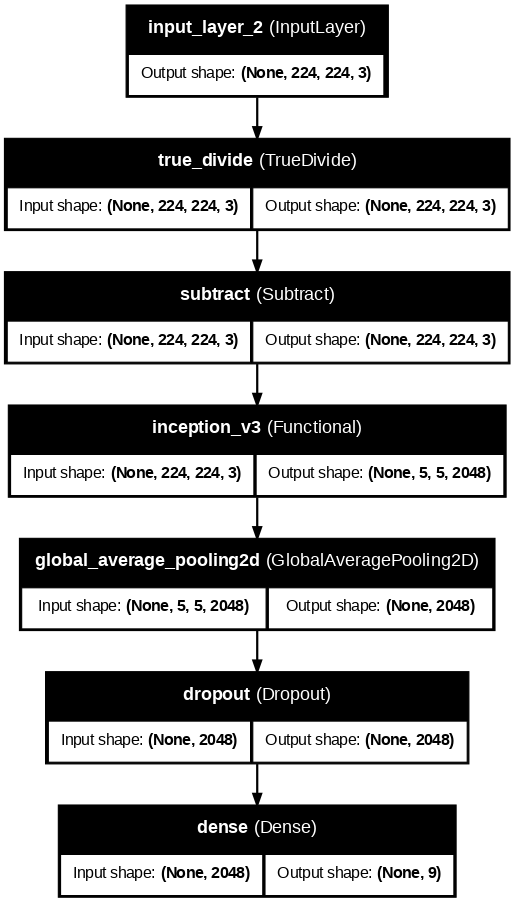

In [20]:
# Import the plot_model function from Keras
from tensorflow.keras.utils import plot_model

# Plot and save the model architecture as a PNG image
plot_model(
    model,                      # Your Keras model
    to_file='model_architecture.png',  # File name for saving the image
    show_shapes=True,           # Display input/output shapes for each layer
    show_layer_names=True,      # Display layer names
    dpi=80                      # Set resolution (smaller DPI → smaller image)
)


##### 🔹 Model Checkpoint & Save
* Save the best model during training using **checkpoints**, and optionally save the final trained model.


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
## set the path name as *dataset/Lr/optimizer_name/model_name*
model_filepath="/content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/inceptionv3-{epoch:02d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath = model_filepath ,
    monitor ='val_accuracy',
    mode = 'max' ,
    save_best_only =True ,
    verbose = 1
)

##### 🔹 Load / Set Model Weights
* Load pre-trained weights or initialize custom weights for the CNN model.


In [22]:
# Assuming you already have Dataset as a list of samples per class
# or you can compute from train_dataset using:
# class_counts = [sum(1 for _, label in train_dataset.unbatch().as_numpy_iterator() if label==i) for i in range(n_classes)]

total = sum(Dataset)        # total number of images
class_weight = {}

for i, count in enumerate(Dataset):
    class_weight[i] = (1 / count) * (total / len(Dataset))

# Print class weights
for i, w in class_weight.items():
    print(f"Weight for class {i}: {w:.2f}")


Weight for class 0: 2.06
Weight for class 1: 0.85
Weight for class 2: 0.88
Weight for class 3: 1.04
Weight for class 4: 0.86
Weight for class 5: 1.07
Weight for class 6: 0.86
Weight for class 7: 0.83
Weight for class 8: 1.31


In [24]:
# Suppose you have 9 classes
num_classes = 9

# Set all class weights to 1
class_weights = {i: 1.0 for i in range(num_classes)}


##### 🔹 Train the Model
* Train the CNN model using the training dataset, validate on the validation dataset, and store the training history.


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

# Start timer before training
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# Train the model
## change hyperparameter such as epoches
history = model.fit(train_dataset , verbose=2 , epochs=25 , class_weight=class_weights ,                         validation_data=valid_dataset ,
                    callbacks =[checkpoint])

# End timer
end_time = time.time()

# Calculate training duration in minutes
training_time_mins = (end_time - start_time) / 60

print(f"🕒 Total Training Time: {training_time_mins:.2f} minutes")

Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.57692, saving model to /content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/inceptionv3-01-0.5769.keras
16/16 - 93s - 6s/step - accuracy: 0.6503 - loss: 1.0578 - val_accuracy: 0.5769 - val_loss: 1.3021
Epoch 2/25

Epoch 2: val_accuracy improved from 0.57692 to 0.79487, saving model to /content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/inceptionv3-02-0.7949.keras
16/16 - 8s - 518ms/step - accuracy: 0.9441 - loss: 0.2615 - val_accuracy: 0.7949 - val_loss: 0.6598
Epoch 3/25

Epoch 3: val_accuracy improved from 0.79487 to 0.83333, saving model to /content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/inceptionv3-03-0.8333.keras
16/16 - 8s - 514ms/step - accuracy: 0.9795 - loss: 0.1215 - val_accuracy: 0.8333 - val_loss: 0.4418
Epoch 4/25

Epoch 4: val_accuracy improved from 0.83333 to 0.87179, saving model to /content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/inceptionv3-04-0.8718.keras
16/16 - 8s - 524ms/step - accuracy: 0.992

##### 🔹 Test the Model
* Evaluate the trained model on the test dataset.




In [45]:
import tensorflow as tf

test_path = '/content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/bangla_banknote_v2/Training/split/test'

# Recreate test dataset (only existing files will be included)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # or 'categorical' if your model uses one-hot
)

# Evaluate the model
model.evaluate(test_dataset, verbose=1)


Found 92 files belonging to 9 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8979 - loss: 0.2792


[0.26102158427238464, 0.9130434989929199]

# Step 4: Results & Visualizations
Evaluate model performance and visualize key metrics and results.

##### 🔹 Actual vs Predicted Classes

*  Visualize the model’s predictions compared to true labels on the test dataset.
*   Collect **one example per class** from `test_dataset`.




1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


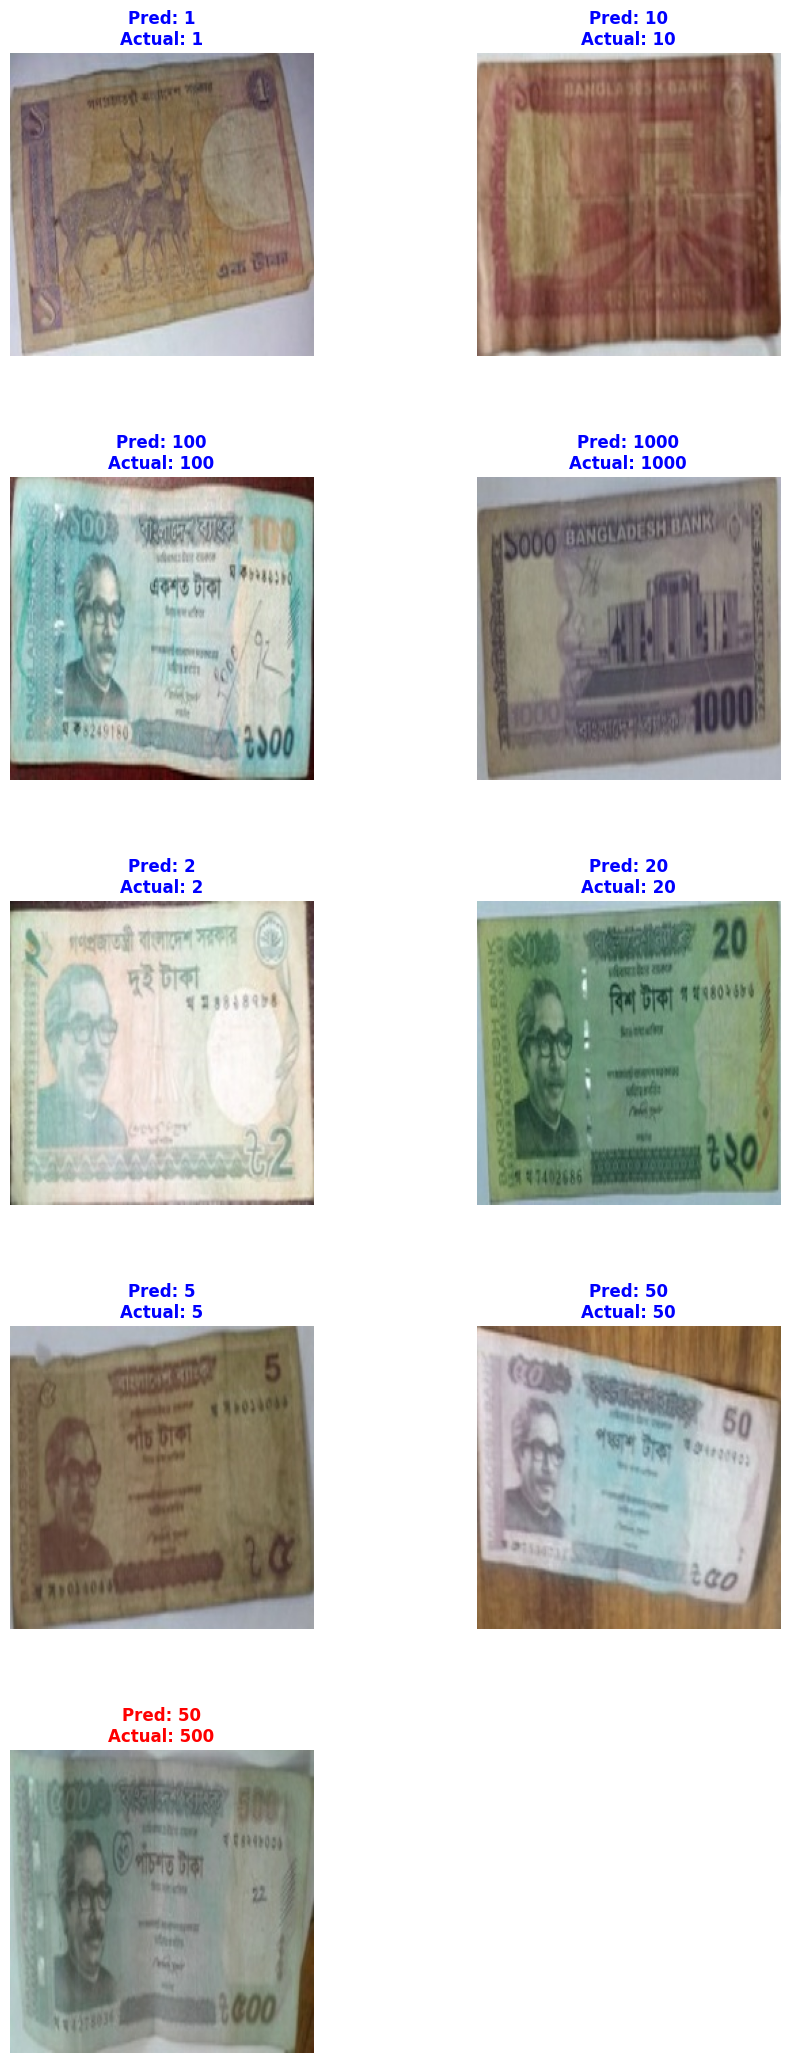

In [46]:
examples = {}
for images, labels in test_dataset.unbatch().take(1000):  # take enough to find all classes
    class_idx = labels.numpy()
    if class_idx not in examples:
        examples[class_idx] = images
    if len(examples) == n_classes:
        break

# Plotting
cols = 2  # number of columns
rows = math.ceil(n_classes / cols)
plt.figure(figsize=(cols * 5, rows * 5))

for i, class_idx in enumerate(sorted(examples.keys())):
    img = examples[class_idx].numpy().astype("uint8")
    img_exp = tf.expand_dims(img, 0)  # expand batch dim
    predict = model.predict(img_exp)
    predicted = class_names[np.argmax(predict)]
    actual = class_names[class_idx]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    color = 'blue' if predicted == actual else 'red'
    plt.title(f"Pred: {predicted}\nActual: {actual}", fontsize=12, fontweight='bold', color=color)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                        top=0.9, wspace=0.4, hspace=0.4)

plt.show()

##### 🔹 Actual vs Predicted Images

*   Display sample images from the test set with their **true labels and model predictions** for qualitative evaluation.
*   Show **three images per class** for qualitative evaluation.


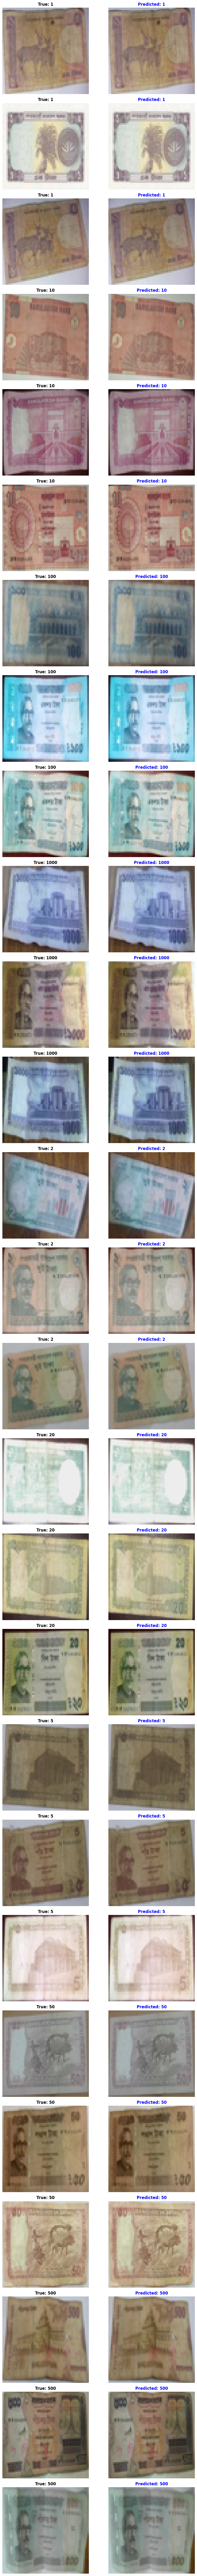

In [47]:
# Function to load multiple random images per class
def load_images_per_class(folder, num_images_per_class=3):
    images = []
    labels = []
    class_names = []

    for class_idx, subfolder in enumerate(sorted(os.listdir(folder))):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            class_names.append(subfolder)
            image_files = os.listdir(subfolder_path)
            selected_files = random.sample(image_files, min(num_images_per_class, len(image_files)))
            for image_file in selected_files:
                img_path = os.path.join(subfolder_path, image_file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((64, 64))
                images.append(np.array(img)/255.0)
                labels.append(class_idx)

    return np.array(images), np.array(labels), class_names

# Path to your test folder
test_folder = test_directory

# Load images: change num_images_per_class as needed
num_images_per_class = 3
images, labels, class_names = load_images_per_class(test_folder, num_images_per_class=num_images_per_class)

# Example predicted labels (replace with your model predictions)
predicted_labels = labels.copy()  # For demo, assume correct predictions

# Automatically calculate subplot grid
total_images = len(images)
cols = 2  # Original + Predicted
rows = total_images  # Each image gets a row

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

if rows == 1:  # Special case if only 1 image
    axes = np.expand_dims(axes, axis=0)

for i in range(total_images):
    img = images[i]
    true_label = class_names[labels[i]]
    predicted_label = class_names[predicted_labels[i]]

    # Original
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'True: {true_label}', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')

    # Predicted
    axes[i, 1].imshow(img)
    color = 'blue' if true_label == predicted_label else 'red'
    axes[i, 1].set_title(f'Predicted: {predicted_label}', fontsize=12, fontweight='bold', color=color)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


##### 🔹 Label Binarization
* Binarize class labels and evaluate model performance using metrics like **accuracy, precision, recall, and F1-score**.


In [48]:
from sklearn.preprocessing import label_binarize

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Binarize the true and predicted labels
true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
predicted_labels_bin = label_binarize(predicted_labels, classes=np.unique(predicted_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


##### 🔹 Classification Report
* Provides precision, recall, F1-score, and support for each class to summarize model performance.


In [49]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
          10       1.00      0.82      0.90        11
         100       0.86      1.00      0.92        12
        1000       1.00      1.00      1.00        10
           2       0.92      1.00      0.96        12
          20       0.90      0.90      0.90        10
           5       0.92      0.92      0.92        12
          50       0.86      1.00      0.92        12
         500       0.80      0.50      0.62         8

    accuracy                           0.91        92
   macro avg       0.92      0.90      0.90        92
weighted avg       0.91      0.91      0.91        92



##### 🔹 Confusion Matrix
* Visualize the **confusion matrix** to assess class-wise prediction performance.

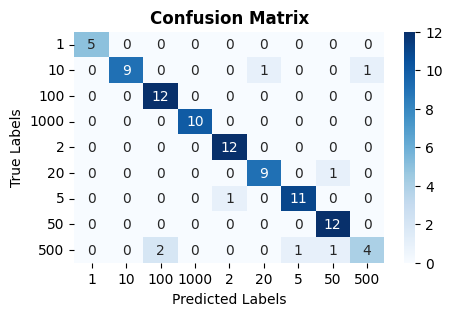

In [50]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontweight='bold')
plt.show()

##### 📈 Training and Validation Accuracy & Training and Validation Loss
* Visualize the model's **training and validation accuracy and loss** over epochs to assess learning and overfitting.

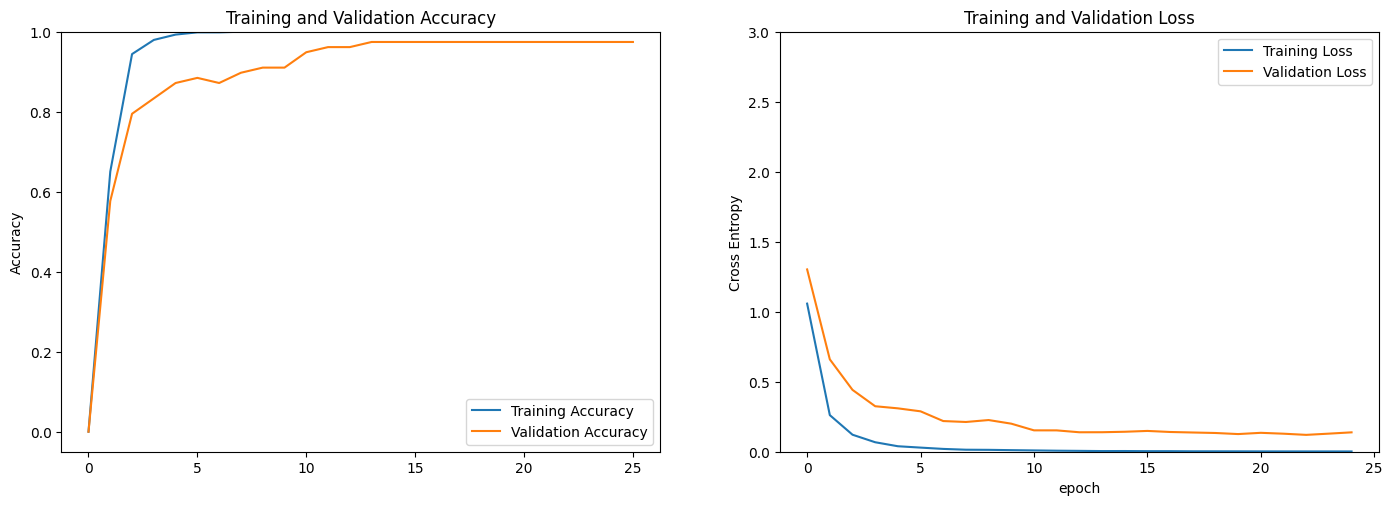

In [51]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### 📈 ROC curve
*   Plot the **ROC curve** to evaluate model performance.
*  **One-vs-Rest** for multiclass and
 **One-vs-One** for binary classification.

In [52]:
from sklearn.metrics import roc_curve, auc

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:     # or valid_dataset if you want
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Shape of predictions:", y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Shape of predictions: (92, 9)


In [53]:
# Binarize labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


/tmp/ipython-input-860881180.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_classes)  # 'tab20' or 'tab10', n_classes colors


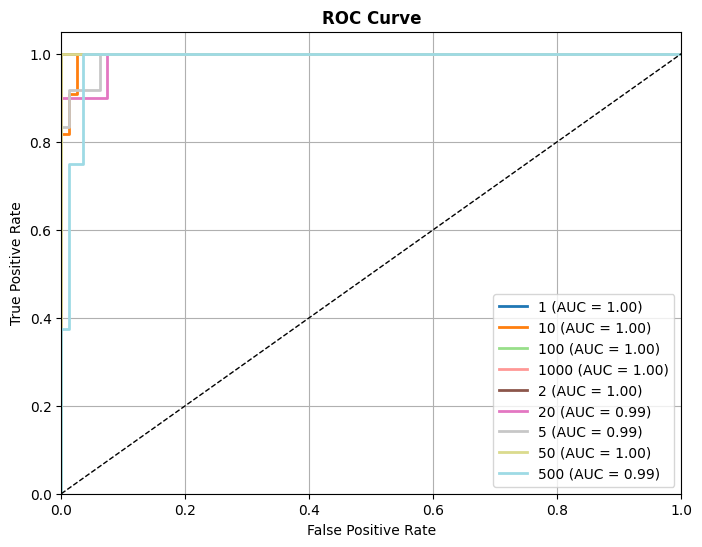

In [54]:
import matplotlib.cm as cm

plt.figure(figsize=(8, 6))

# Automatically generate colors
colors = cm.get_cmap('tab20', n_classes)  # 'tab20' or 'tab10', n_classes colors

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##### 🔹 Right vs Wrong Classifier
* Visualize and analyze **correctly and incorrectly classified samples** to understand model performance.

In [55]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate total right and wrong predictions
total_right = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
total_wrong = sum(1 for true, pred in zip(true_labels, predicted_labels) if true != pred)
total_samples = len(true_labels)

print("Total Right Predictions:", total_right)
print("Total Wrong Predictions:", total_wrong)

# Calculate percentages
right_percentage = (total_right / total_samples) * 100
wrong_percentage = (total_wrong / total_samples) * 100

# Data for the bar plot
labels = ['Right', 'Wrong']
percentages = [right_percentage, wrong_percentage]

Total Right Predictions: 84
Total Wrong Predictions: 8


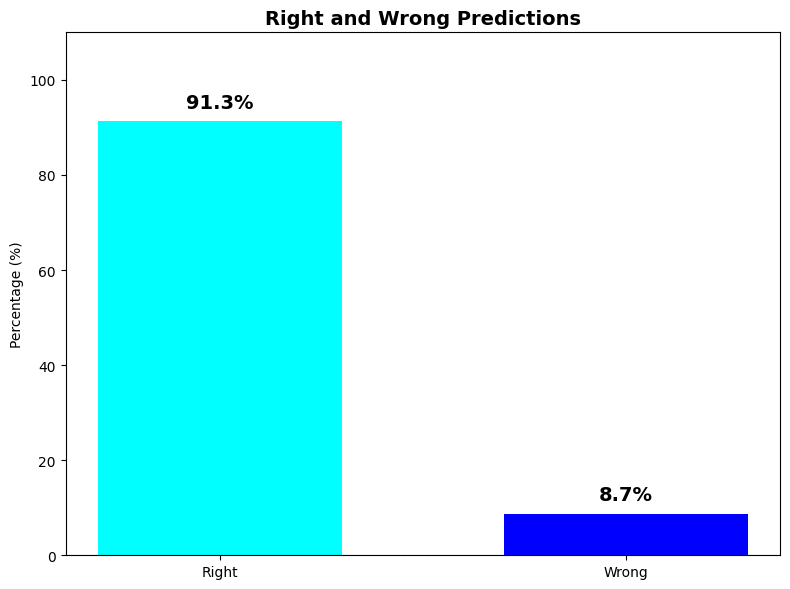

In [56]:
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, percentages, color=['cyan', 'blue'], width=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.1f}%',
             ha='center',fontsize=14,fontweight='bold', va='bottom')

plt.title('Right and Wrong Predictions', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)')
plt.ylim(0, 110)  # add padding on top
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')

plt.tight_layout()
plt.show()


##### 🔹 Model Evaluation Metrics
* Summarize the model's performance using multiple metrics: **Accuracy**, **Precision**, **Recall (Sensitivity)**, **F1 Score**, **Negative Predictive Value (NPV)**, **AUC-ROC**

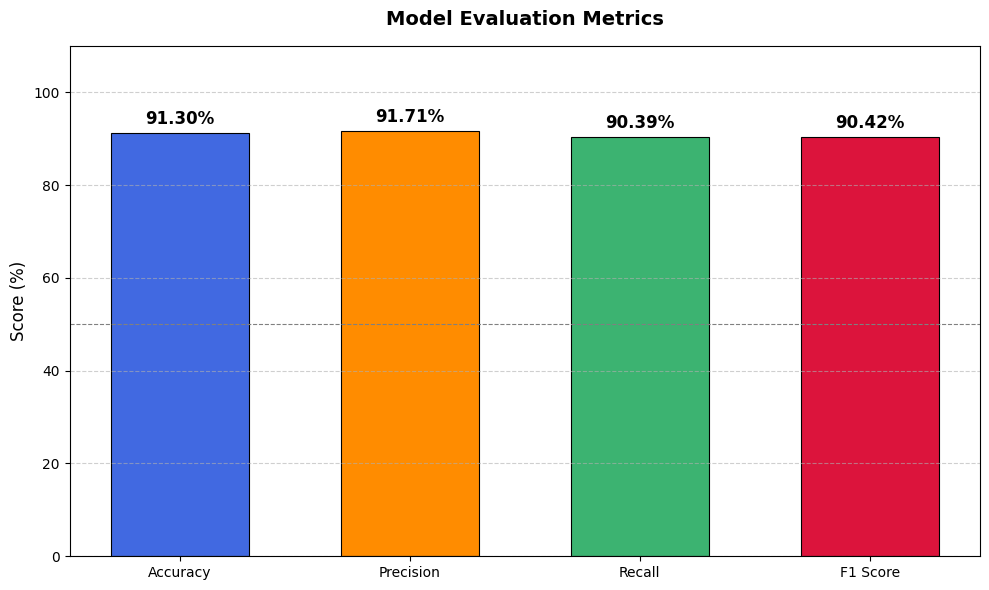

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ----- Metric Computation -----
n_classes = len(np.unique(true_labels))

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Binary: compute NPV and AUC
if n_classes == 2:
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    auc = roc_auc_score(true_labels, predicted_labels)
else:
    npv = np.nan
    auc = np.nan

metrics = {
    'Accuracy': accuracy * 100,
    'Precision': precision * 100,
    'Recall': recall * 100,
    'F1 Score': f1 * 100,
    'NPV': npv * 100 if not np.isnan(npv) else np.nan,
    'AUC-ROC': auc * 100 if not np.isnan(auc) else np.nan
}

# ----- Plotting -----
plt.figure(figsize=(10, 6))

bars = plt.bar(metrics.keys(), metrics.values(),
               color=['royalblue', 'darkorange', 'mediumseagreen', 'crimson', 'orchid', 'deepskyblue'],
               width=0.6, edgecolor='black', linewidth=0.8)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):  # skip NaNs
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1.0, f'{yval:.2f}%',  # show % with 2 decimals
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Model Evaluation Metrics', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Score (%)', fontsize=12)
plt.ylim(0, 110)  # allow space above 100%
plt.axhline(y=50, color='grey', linestyle='--', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [60]:
# Print metric values
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 91.3043
Precision: 91.7114
Recall: 90.3872
F1 Score: 90.4245
NPV: nan
AUC-ROC: nan


##### 🔹 Cohen's Kappa
* Measure agreement between predicted and true labels beyond chance.

In [61]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f'Cohen\'s Kappa: {kappa:.4f}')

Cohen's Kappa: 0.9014


##### 🔹 Matthews Correlation Coefficient (MCC)
* Assess overall classification quality considering all confusion matrix terms.

In [62]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# Assuming true_labels and predicted_labels are multiclass labels
mcc_values = [matthews_corrcoef(true_labels == i, predicted_labels == i) for i in np.unique(true_labels)]

average_mcc = np.mean(mcc_values)
print(f'Average Matthews Correlation Coefficient for Multiclass: {average_mcc:.4f}')

Average Matthews Correlation Coefficient for Multiclass: 0.8973


##### 🔹 Sensitivity & Specificity
* Evaluate each class's **sensitivity (recall)** and **specificity** based on true positives and true negatives


In [63]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
n_classes = cm.shape[0]

# If binary classification
if n_classes == 2:
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print("Binary Classification:")
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")

# If multiclass classification
else:
    # Sensitivity = TP / (TP + FN)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    # Specificity = TN / (TN + FP)
    specificity = []
    for i in range(n_classes):
        # For each class, treat it as "positive" vs "rest"
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm, i, axis=0)[:, i])
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    specificity = np.array(specificity)

    print("Multiclass Classification:")
    for i in range(n_classes):
        print(f"Class {i}: Sensitivity={sensitivity[i]:.3f}, Specificity={specificity[i]:.3f}")

    print(f"\nAverage Sensitivity: {np.mean(sensitivity):.3f}")
    print(f"Average Specificity: {np.mean(specificity):.3f}")


Multiclass Classification:
Class 0: Sensitivity=1.000, Specificity=1.000
Class 1: Sensitivity=0.818, Specificity=1.000
Class 2: Sensitivity=1.000, Specificity=0.975
Class 3: Sensitivity=1.000, Specificity=1.000
Class 4: Sensitivity=1.000, Specificity=0.988
Class 5: Sensitivity=0.900, Specificity=0.988
Class 6: Sensitivity=0.917, Specificity=0.988
Class 7: Sensitivity=1.000, Specificity=0.975
Class 8: Sensitivity=0.500, Specificity=0.988

Average Sensitivity: 0.904
Average Specificity: 0.989


Overall Sensitivity (Recall): 0.904
Overall Specificity: 0.989


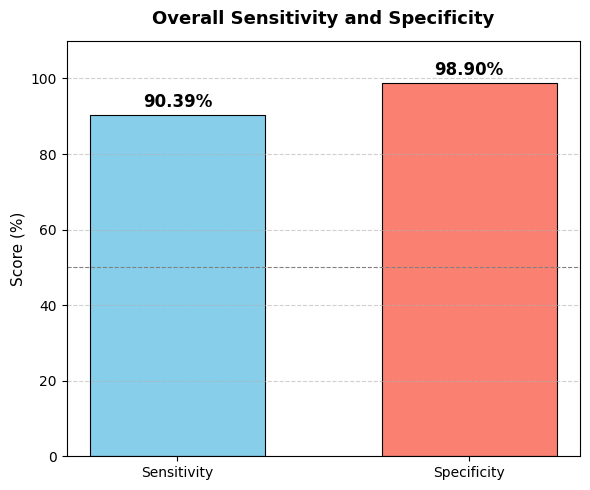

In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# --- Compute Sensitivity & Specificity ---
cm = confusion_matrix(true_labels, predicted_labels)
n_classes = cm.shape[0]

# Sensitivity (macro average): TP / (TP + FN)
sensitivity_per_class = np.diag(cm) / np.sum(cm, axis=1)
sensitivity = np.nanmean(sensitivity_per_class)

# Specificity (macro average): TN / (TN + FP)
specificity_list = []
for i in range(n_classes):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    specificity_list.append(tn / (tn + fp) if (tn + fp) > 0 else np.nan)
specificity = np.nanmean(specificity_list)

print(f"Overall Sensitivity (Recall): {sensitivity:.3f}")
print(f"Overall Specificity: {specificity:.3f}")

# --- Plotting ---
metrics = ['Sensitivity', 'Specificity']
values = [sensitivity * 100, specificity * 100]  # Convert to percentage

plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values,
               color=['skyblue', 'salmon'],
               width=0.6, edgecolor='black', linewidth=0.8)

# Add percentage labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1.0, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Overall Sensitivity and Specificity', fontsize=13, fontweight='bold', pad=12)
plt.ylabel('Score (%)', fontsize=11)
plt.ylim(0, 110)  # Add headroom for labels
plt.axhline(y=50, color='grey', linestyle='--', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### 🔹 Jaccard Index & Dice Score
* Measure overlap between predicted and true classes using **Jaccard Index (IoU)** and **Dice Score**.


Overall Jaccard Index: 0.840
Overall Dice Score: 0.904


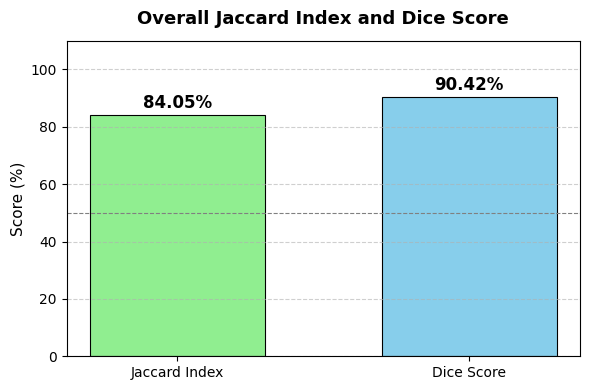

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# --- Compute confusion matrix and scores ---
cm = confusion_matrix(true_labels, predicted_labels)
n_classes = cm.shape[0]

jaccard_per_class = []
dice_per_class = []

for i in range(n_classes):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp

    # Jaccard Index
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else np.nan
    jaccard_per_class.append(jaccard)

    # Dice Score
    dice = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else np.nan
    dice_per_class.append(dice)

# Macro-average (overall)
jaccard_index = np.nanmean(jaccard_per_class)
dice_score = np.nanmean(dice_per_class)

print(f"Overall Jaccard Index: {jaccard_index:.3f}")
print(f"Overall Dice Score: {dice_score:.3f}")

# --- Plotting ---
metrics = ['Jaccard Index', 'Dice Score']
values = [jaccard_index * 100, dice_score * 100]  # convert to %

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values,
               color=['lightgreen', 'skyblue'],
               width=0.6, edgecolor='black', linewidth=0.8)

# Add percentage labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1.0, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Overall Jaccard Index and Dice Score', fontsize=13, fontweight='bold', pad=12)
plt.ylabel('Score (%)', fontsize=11)
plt.ylim(0, 110)  # headroom for labels
plt.axhline(y=50, color='grey', linestyle='--', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### 🔹 PR-AUC (Precision-Recall AUC)
* Evaluate model performance using the **area under the Precision-Recall curve**, especially useful for imbalanced datasets.

In [68]:
from sklearn.metrics import precision_recall_curve, auc

# Get true labels and predicted probabilities
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)

# Handle binary or multiclass
if y_pred_probs.shape[1] == 2:  # binary
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs[:, 1])
    pr_auc = auc(recall, precision)
else:  # multiclass
    pr_auc = {}
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=range(y_pred_probs.shape[1]))
    for i in range(y_pred_probs.shape[1]):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
        pr_auc[i] = auc(recall, precision)

print("PR-AUC:", pr_auc)


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
PR-AUC: {0: np.float64(0.063447545876482), 1: np.float64(0.11242395751827572), 2: np.float64(0.09949856336849558), 3: np.float64(0.10449151796010715), 4: np.float64(0.23500618101344534), 5: np.float64(0.12183641793131231), 6: np.float64(0.16006102447901638), 7: np.float64(0.12916774349372445), 8: np.float64(0.20289254768763285)}


##### 🔹 Log Loss / Cross-Entropy Loss
* Evaluate prediction confidence using **log loss** (cross-entropy) between true and predicted probabilities.

In [69]:
from sklearn.metrics import log_loss

y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)

loss = log_loss(y_true, y_pred_probs)
print("Log Loss / Cross-Entropy Loss:", loss)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Log Loss / Cross-Entropy Loss: 7.893155947519785


##### 🔹 Top-k Accuracy
* Measure if the **true label** is among the model's **top k predicted classes** in multiclass classification.

In [70]:
# Top-k accuracy automatically for multiclass
k = 3  # you can change k
top_k_acc = tf.keras.metrics.TopKCategoricalAccuracy(k=k)

y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)

# Convert binary labels to categorical if needed
if y_pred_probs.shape[1] == 2 and len(np.unique(y_true)) == 2:
    from tensorflow.keras.utils import to_categorical
    y_true_cat = to_categorical(y_true, num_classes=2)
else:
    y_true_cat = tf.keras.utils.to_categorical(y_true, num_classes=y_pred_probs.shape[1])

top_k_acc.update_state(y_true_cat, y_pred_probs)
print(f"Top-{k} Accuracy:", top_k_acc.result().numpy())

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
Top-3 Accuracy: 0.3478261


##### 🔹 G-Mean (Geometric Mean of Sensitivity & Specificity)
* Compute the **G-Mean** to evaluate balanced classification performance.

In [71]:
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

cm = confusion_matrix(y_true, y_pred)
if cm.shape[0] == 2:  # binary
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    g_mean = math.sqrt(sensitivity * specificity)
else:  # multiclass: compute G-mean per class and average
    sensitivity_list = []
    specificity_list = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        sensitivity_list.append(tp / (tp + fn) if (tp+fn)>0 else 0)
        specificity_list.append(tn / (tn + fp) if (tn+fp)>0 else 0)
    g_mean = np.mean(np.sqrt(np.array(sensitivity_list) * np.array(specificity_list)))

print("G-Mean:", g_mean)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
G-Mean: 0.32339918765284553


#### 🔥 Grad-CAM Visualization
Generate **Grad-CAM heatmaps** to visualize the regions of input images that the **CNN** model focuses on for its predictions.


##### 🔹 Grad-CAM
* Gradient-weighted Class Activation Mapping
* Highlights important regions in an image using gradients flowing into the last convolutional layer.  

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_img_array(img_path, target_size=(224,224)):
    """Load and preprocess image"""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.keras.applications.densenet.preprocess_input(array)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """Overlay heatmap on original image"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap_color, alpha, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# -------------------------
# Example Usage
# -------------------------
img_path = "/content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/bangla_banknote_v2/Testing/0.jpg"
img_array = get_img_array(img_path, target_size=(224,224))

# DenseNet121 last conv layer for Grad-CAM
last_conv_layer_name = "mix10"

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(img_path, heatmap)


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_original_and_gradcam(img_path, heatmap, alpha=0.4):
    """Display original image and Grad-CAM side by side with titles"""

    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create Grad-CAM overlay
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap_color, alpha, 0)

    # Plot side by side
    plt.figure(figsize=(12,6))

    # Original image
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image", fontsize=14, fontweight='bold')
    plt.axis('off')

    # Grad-CAM image
    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM", fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------
# Example Usage
# -------------------------
img_path = "/content/drive/MyDrive/sample_dataset/test/10/157.jpg"
img_array = get_img_array(img_path, target_size=(224,224))

# Grad-CAM heatmap
last_conv_layer_name = "conv5_block16_2_conv"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display comparison
display_original_and_gradcam(img_path, heatmap)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# -------------------------
# Helper functions
# -------------------------
def get_img_array(img_path, target_size=(224,224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.keras.applications.densenet.preprocess_input(array)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

def display_original_and_gradcam(img_path, heatmap, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create Grad-CAM overlay
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap_color, alpha, 0)

    # Plot side by side
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image", fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM", fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------
# Main function
# -------------------------
def gradcam_one_image_per_class(model, test_directory, last_conv_layer_name="conv5_block16_2_conv"):
    """
    Generate Grad-CAM for ONE image from each true class folder.
    """
    # Get class names from folder names
    class_names = sorted([d for d in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, d))])

    for class_name in class_names:
        class_path = os.path.join(test_directory, class_name)

        # Pick the first image from the folder
        img_name = os.listdir(class_path)[0]
        img_path = os.path.join(class_path, img_name)

        # Preprocess for model
        img_array = get_img_array(img_path, target_size=(224,224))

        # Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Display
        display_original_and_gradcam(img_path, heatmap)

# -------------------------
# Example usage
# -------------------------
test_directory = "/content/drive/MyDrive/sample_dataset/train"
gradcam_one_image_per_class(model, test_directory)


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

def get_img_array(img_path, target_size=(224,224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.keras.applications.densenet.preprocess_input(array)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

def display_original_and_gradcam(img_path, heatmap, alpha=0.4, class_name=None, pred_prob=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap_color, alpha, 0)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image", fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    title_text = "Grad-CAM"
    if class_name is not None and pred_prob is not None:
        title_text += f"\nPred: {class_name} ({pred_prob*100:.1f}%)"
    plt.title(title_text, fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def gradcam_one_image_per_class(model, test_directory, last_conv_layer_name="conv5_block16_2_conv"):
    """
    Generate Grad-CAM for ONE image from each true class folder.
    """
    # Get class names from folder names
    class_names = sorted([d for d in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, d))])

    for class_name in class_names:
        class_path = os.path.join(test_directory, class_name)

        # Pick the first image from the folder
        img_name = os.listdir(class_path)[0]
        img_path = os.path.join(class_path, img_name)

        # Preprocess
        img_array = get_img_array(img_path, target_size=(224,224))

        # Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Prediction
        preds = model.predict(img_array, verbose=0)
        pred_index = np.argmax(preds[0])
        pred_prob = preds[0][pred_index]
        # Map predicted index to folder names
        pred_class_name = class_names[pred_index] if pred_index < len(class_names) else f"Class {pred_index}"

        # Display side-by-side
        display_original_and_gradcam(img_path, heatmap, class_name=pred_class_name, pred_prob=pred_prob)

# -------------------------
# Example usage
# -------------------------
test_directory = "/content/drive/MyDrive/sample_dataset/train"
gradcam_one_image_per_class(model, test_directory)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# -------------------------
# Helper functions
# -------------------------

def get_img_array(img_path, target_size=(224,224)):
    """Load image and convert to array suitable for model input"""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.keras.applications.densenet.preprocess_input(array)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Compute Grad-CAM heatmap for a single image"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def display_original_and_gradcam(img_path, heatmap, true_class=None, pred_class=None, pred_prob=None, alpha=0.4):
    """Display original image and Grad-CAM overlay side by side"""
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create Grad-CAM overlay
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap_color, alpha, 0)

    # Plot
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original Image\nTrue: {true_class}", fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    title_text = "Grad-CAM"
    if pred_class is not None and pred_prob is not None:
        title_text += f"\nPred: {pred_class} ({pred_prob*100:.1f}%)"
    plt.title(title_text, fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------
# Main function
# -------------------------

def gradcam_one_image_per_class(model, test_directory, last_conv_layer_name="conv5_block16_2_conv"):
    """
    Generate Grad-CAM for ONE image from each class folder.
    """
    # Automatically detect class folders
    class_names = sorted([d for d in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, d))])

    for true_class in class_names:
        class_path = os.path.join(test_directory, true_class)

        # Pick the first image in the folder
        img_name = os.listdir(class_path)[0]
        img_path = os.path.join(class_path, img_name)

        # Preprocess
        img_array = get_img_array(img_path, target_size=(224,224))

        # Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Prediction
        preds = model.predict(img_array, verbose=0)
        pred_index = np.argmax(preds[0])
        pred_prob = float(preds[0][pred_index])

        # Map prediction index to class name safely
        pred_class = class_names[pred_index] if pred_index < len(class_names) else f"Class {pred_index}"

        # Display
        display_original_and_gradcam(img_path, heatmap, true_class=true_class, pred_class=pred_class, pred_prob=pred_prob)

# -------------------------
# Example usage
# -------------------------
test_directory = "/content/drive/MyDrive/sample_dataset/train"
gradcam_one_image_per_class(model, test_directory)


##### 🔹 Grad-CAM++
* Improved version of Grad-CAM that better localizes multiple occurrences of objects.

In [ ]:
# -------------------------
# Grad-CAM++ helper functions
# -------------------------
def make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Compute Grad-CAM++ heatmap for a single image
    Reference: Chattopadhyay et al., Grad-CAM++ (2018)
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            conv_outputs, predictions = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]
        grads = tape2.gradient(class_channel, conv_outputs)  # first-order gradient
    grads2 = tape1.gradient(grads, conv_outputs)             # second-order gradient

    conv_outputs = conv_outputs[0]
    grads = grads[0]
    grads2 = grads2[0]

    # Compute alpha for Grad-CAM++
    numerator = grads2
    denominator = 2 * grads2 + tf.reduce_sum(conv_outputs * grads2, axis=(0, 1))
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))  # avoid div by 0
    alphas = numerator / denominator

    weights = tf.reduce_sum(tf.nn.relu(alphas * tf.nn.relu(grads)), axis=(0, 1))
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)

    # Normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap + 1e-10)

    return heatmap.numpy()

# -------------------------
# Display function for Grad-CAM++
# -------------------------
def display_original_and_gradcam_plus_plus(img_path, heatmap, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create Grad-CAM++ overlay
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap_color, alpha, 0)

    # Plot side by side
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image", fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM++", fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------
# Main function for Grad-CAM++
# -------------------------
def gradcam_plus_plus_one_image_per_class(model, test_directory, last_conv_layer_name="conv5_block16_2_conv"):
    """
    Generate Grad-CAM++ for ONE image from each true class folder.
    """
    # Get class names from folder names
    class_names = sorted([d for d in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, d))])

    for class_name in class_names:
        class_path = os.path.join(test_directory, class_name)

        # Pick the first image from the folder
        img_name = os.listdir(class_path)[0]
        img_path = os.path.join(class_path, img_name)

        # Preprocess for model
        img_array = get_img_array(img_path, target_size=(224,224))

        # Grad-CAM++ heatmap
        heatmap = make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name)

        # Display
        display_original_and_gradcam_plus_plus(img_path, heatmap)

# -------------------------
# Example usage
# -------------------------
test_directory = "/content/drive/MyDrive/sample_dataset/train"
gradcam_plus_plus_one_image_per_class(model, test_directory)


##### 🔹 Score-CAM
* Generates heatmaps by weighting activation maps with forward-pass scores, no gradients needed.  

##### 🔹 Faster Score-CAM  
A speed-optimized version of Score-CAM that reduces the number of forward passes while generating heatmaps.


##### 🔹 LIME
* Explains model predictions by perturbing superpixels and fitting a local interpretable model.

In [ ]:
!pip install lime

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image

def plot_lime_single_image(model, img_path, class_names, num_samples=1000):
    # Load image and convert to array
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)

    # Prediction function for LIME
    def predict_fn(images):
        images_preprocessed = tf.keras.applications.densenet.preprocess_input(images.astype(np.float32))
        return model.predict(images_preprocessed)

    # LIME explainer
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.uint8(img_array),
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples
    )

    # Get top predicted class explanation
    top_class = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_class,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    lime_img = mark_boundaries(temp / 255.0, mask)

    # Plot original and LIME side by side
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title("Original Image", fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(lime_img)
    plt.title(f"LIME Explanation\nPred: {class_names[top_class]}", fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
test_image_path = "/content/drive/MyDrive/sample_dataset/train/10/130.jpg"
plot_lime_single_image(model, test_image_path, class_names)


#### 🔥 SHAP
* SHapley Additive exPlanations
* SHAP uses **Shapley values** to show each input pixel's contribution to the model's prediction, highlighting important regions in the image.


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# -------------------------
# SHAP visualization function
# -------------------------
def plot_shap_image(model, img_path, class_names, num_samples=50):
    """
    Generate SHAP explanation for a single image.
    """
    # Load image
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_input = np.expand_dims(img_array, axis=0)
    img_input_pre = tf.keras.applications.densenet.preprocess_input(img_input.astype(np.float32))

    # Model prediction
    preds = model.predict(img_input_pre)
    pred_index = np.argmax(preds[0])
    pred_prob = preds[0][pred_index]
    pred_class_name = class_names[pred_index]

    # Define a function for SHAP to call
    def f(x):
        x_pre = tf.keras.applications.densenet.preprocess_input(x.astype(np.float32))
        return model.predict(x_pre)

    # SHAP DeepExplainer
    # Use a small background dataset for efficiency (here just using the same image multiple times)
    background = img_input_pre
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(img_input_pre)

    # Convert SHAP values to a heatmap for the predicted class
    heatmap = np.mean(np.abs(shap_values[pred_index]), axis=-1)[0]  # shape: (224,224)
    heatmap = heatmap / np.max(heatmap + 1e-10)  # normalize 0-1

    # Overlay heatmap on image
    img_uint8 = img_array.astype(np.uint8)
    cmap = plt.get_cmap('jet')
    heatmap_color = cmap(heatmap)[...,:3]  # RGB
    superimposed_img = (0.6*img_uint8/255.0 + 0.4*heatmap_color)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Plot side by side
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img_uint8)
    plt.title("Original Image", fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title(f"SHAP Explanation\nPred: {pred_class_name} ({pred_prob*100:.1f}%)",
              fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------
# Example usage
# -------------------------
test_image_path = "/content/drive/MyDrive/Bengali_Taka/BM_S/bangla-money/bangla_banknote_v2/Testing/0.jpg"
plot_shap_image(model, test_image_path, class_names)
